In [1029]:
import random
from Hourbid import *
from Fibid import *
from blockbid import *
import matplotlib.pyplot as plt    

In [1030]:
BS_bids = Blockbid()[0]
BD_bids = Blockbid()[1]
HS_bids = HourBid()[0]
HD_bids = HourBid()[1]
FS_bids = Fibid()[0]
FD_bids = Fibid()[1]

In [1031]:
def Pairs(postion,Hour,DF,QP):
    
    if QP == 'DQ':
        DF=DF.iloc[HIndex_D[Hour][0]:HIndex_D[Hour][1]+1]
        return [DF['Quantity'][postion+HIndex_D[Hour][0]],DF['Quantity'][postion+1+HIndex_D[Hour][0]]]
    if QP == 'SQ':
        DF=DF.iloc[HIndex_S[Hour][0]:HIndex_S[Hour][1]+1]
        return [DF['Quantity'][postion+HIndex_S[Hour][0]],DF['Quantity'][postion+1+HIndex_S[Hour][0]]]
    if QP == 'DP':
        DF=DF.iloc[HIndex_D[Hour][0]:HIndex_D[Hour][1]+1]
        return [DF['price'][postion+HIndex_D[Hour][0]],DF['price'][postion+1+HIndex_D[Hour][0]]]
    else:
        DF=DF.iloc[HIndex_S[Hour][0]:HIndex_S[Hour][1]+1]
        return [DF['price'][postion+HIndex_S[Hour][0]],DF['price'][postion+1+HIndex_S[Hour][0]]]
    
Delta_S = np.zeros([len(BS_bids),24])


Delta_D = np.zeros([len(BD_bids),24])
BD_bids  = Blockbid()[1]
for i in range (len(BD_bids)):
    if BD_bids['Hour'][i]+BD_bids['Duration'][i]<=25:
        Delta_D[i,BD_bids['Hour'][i]-1:(BD_bids['Hour'][i]+BD_bids['Duration'][i])-1] = 1

BS_bids = Blockbid()[0]
for i in range (len(BS_bids)):
    if BS_bids['Hour'][i]+BS_bids['Duration'][i]<=25:
        Delta_S[i,BS_bids['Hour'][i]-1:(BS_bids['Hour'][i]+BS_bids['Duration'][i])-1] = 1

In [1032]:
# Heuristic Algorithm for flexible bids
temp1 = []
for i in range(len(FS_bids)):
    temp1.append(random.randint(0,23))
    
temp2 = []
for i in range(len(FD_bids)):
    temp2.append(random.randint(0,23))
    
def HA_FB():
    for h in range(24):
        res1=[[0 for i in range(len(FS_bids))] for i in range(24)]
        res2=[[0 for i in range(len(FD_bids))] for i in range(24)]
        x1=np.where(np.array(temp1)==h)[0]
        x2=np.where(np.array(temp2)==h)[0]
        for j in x1:
            res1[h][j] = 1.0
        for k in x2:
            res2[h][k] = 1.0
    return res1,res2

In [1033]:
# Heuristic Algorithm for Block bids


def HA_B():
    NoneChild_D=[]
    NoneChild_S=[]

    for i in range(len(BD_bids)):
        if BD_bids.isnull()['LinkID'][i] == True:
            NoneChild_D.append(i)
    for i in range(len(BS_bids)):
        if BS_bids.isnull()['LinkID'][i] == True:
            NoneChild_S.append(i)
    BD=[ 0 for i in range(len(BD_bids))]
    BS=[ 0 for i in range(len(BS_bids))]
    for i in NoneChild_D:
        BD[i] = random.randint(0,1)
    for i in NoneChild_S:
        BS[i] = random.randint(0,1)
    return BS,BD

In [1034]:
def find_f(a1,a2,b1,b2,x):
    grad = (b2-b1)/(a2-a1)
    b = b2-grad*a2
    return grad*x+b

def aggregate(h,BS,BD,FS,FD):
    a = 0+h*1000
    b = 1000+h*1000
    agg_q=[]
    agg_p = []
    y1=list(reversed(HD_bids['Quantity'][a:b].tolist()))
    y2=HS_bids['Quantity'][a:b].tolist()
    x1 = list(reversed(HD_bids['price'][a:b].tolist()))
    x2 = HS_bids['price'][a:b].tolist()
    
    # add Block
    for i in range(len(BS)):
        if BS[i] * Delta_S[i][h] >0:
            for j in range(len(y2)):
                y2[j]=y2[j]+BS_bids['Quantity'][i]
    
    for i in range(len(BD)):
        if BD[i] * Delta_D[i][h] >0:
            for j in range(len(y1)):
                y1[j]=y1[j]+BD_bids['Quantity'][i]
    # #  add Flex
    for i in range(len(FS[h])):
        if FS[h][i] == 1:
            for j in range(len(y2)):
                y2[j]=y2[j]+FS_bids['Quantity'][i]
    for i in range(len(FD[h])):
        if FD[h][i] ==1:
            for j in range(len(y1)):
                y1[j]=y1[j]+FD_bids['Quantity'][i]
    
    for i in range(1000):
        if x1[i]==x2[i]:
            agg_q.append(y1[i]-y2[i])
            agg_p.append(x1[i])
        elif x1[i]<x2[i]:
            temp = find_f(x2[i-1],x2[i],y2[i-1],y2[i],x1[i])
            agg_q.append(y1[i]-temp)
            agg_p.append(x1[i])
            temp = find_f(x1[i],x1[i+1],y1[i],y1[i+1],x2[i])
            agg_q.append(temp-y2[i])
            agg_p.append(x2[i])
        elif x2[i]<x1[i]:
            temp = find_f(x1[i-1],x1[i],y1[i-1],y1[i],x2[i])
            agg_q.append(temp-y2[i])
            agg_p.append(x2[i])
            temp = find_f(x2[i],x2[i+1],y2[i],y2[i+1],x1[i])
            agg_q.append(y1[i]-temp)
            agg_p.append(x1[i])

    for i in range(len(agg_q)-1):
        if agg_q[i]*agg_q[i+1] <0:
            grad = (agg_q[i+1]-agg_q[i])/(agg_p[i+1]-agg_p[i])
            b= agg_q[i+1] - agg_p[i+1]*grad
            Res = -b/grad
            if h==0:
                plt.plot(agg_q,agg_p)
                plt.axvline(x=0)
                plt.axhline(y=Res)
            
            return Res
        

$$\left[[HS][HD][FS][FD][BS][BD] \right]$$

In [1052]:
def generate_population():
    population = [[] for i in range(4)]
    BS,BD = HA_B()
    FS,FD = HA_FB()
    
    
    population[2]=FS
    population[3]=FD
    
    population.append(BS)
    population.append(BD)
    
    HS = [np.zeros(999).tolist() for i in range(24)]
    HD = [np.zeros(999).tolist() for i in range(24)]
    
    for h in range(24):
        
        price = aggregate(h,BS,BD,FS,FD)
        BS_INT = np.where(HS_bids['price'][h*1000:1000+h*1000]>price)[0][0]
        breakpoint_S = BS_INT + (price-HS_bids['price'][BS_INT-1+1000*h])/abs((HS_bids['price'][BS_INT+1000*h]-HS_bids['price'][BS_INT-1+1000*h]))-1
        
        BD_INT = np.where(HD_bids['price'][h*1000:1000+h*1000]>price)[0][-1]
        breakpoint_D = BD_INT + 1-(price-HD_bids['price'][BD_INT+1+1000*h])/abs((HD_bids['price'][BD_INT+1000*h]-HD_bids['price'][BD_INT+1+1000*h]))
        
        HS[h][0:int(breakpoint_S)]=np.ones(int(breakpoint_S))
        HS[h][int(breakpoint_S)]=breakpoint_S-int(breakpoint_S)
        
        HD[h][0:int(breakpoint_D)]=np.ones(int(breakpoint_D))
        HD[h][int(breakpoint_D)]=breakpoint_D-int(breakpoint_D)
        
    population[0] = HS
    population[1] = HD
    
    return population

In [1075]:
def fit(population):
    #objective value 
    Hour_S = population[0]
    Hour_D = population[1]
    Block_S = population[4]
    Block_D = population[5]
    Flex_S = population[2]
    Flex_D = population[3]
    
    
    Res_HD= sum(0.5*(2*Pairs(j,i,HD_bids,'DP')[0]+Hour_D[i][j]*(Pairs(j,i,HD_bids,'DP')[1]-Pairs(j,i,HD_bids,'DP')[0]))*Hour_D[i][j]*(Pairs(j,i,HD_bids,'DQ')[1]-Pairs(j,i,HD_bids,'DQ')[0]) for j in range(999) for i in range(24))                
    Res_HS = sum(0.5*(2*Pairs(j,i,HS_bids,'SP')[0]+Hour_S[i][j]*(Pairs(j,i,HS_bids,'SP')[1]-Pairs(j,i,HS_bids,'SP')[0]))*Hour_S[i][j]*(Pairs(j,i,HS_bids,'SQ')[1]-Pairs(j,i,HS_bids,'SQ')[0]) for j in range(999) for i in range(24))   
     
    Res_BD = sum(BD_bids['Duration'][i]*BD_bids['Quantity'][i]*BD_bids['price'][i]*Block_D[i] for i in range(len(Block_D))) 
    Res_BS =  sum(BS_bids['Duration'][i]*BS_bids['Quantity'][i]*BS_bids['price'][i]*Block_S[i] for i in range(len(Block_S)))
    
    Res_FD = sum(FD_bids['Quantity'][i]*FD_bids['price'][i] *sum(Flex_D[h][i] for h in range(24)) for i in range(len(FD_bids))) 
    Res_FS = sum(FS_bids['Quantity'][i]*FS_bids['price'][i] *sum(Flex_S[h][i] for h in range(24)) for i in range(len(FS_bids)))
    
    BA = sum(Pair(1,h,HD_bids,'DQ')[0]-Pair(1,h,HD_bids,'DP')[0] for h in range(24))
    OBJ_V = Res_HD - Res_HS + Res_BD - Res_BS + Res_FD - Res_FS + BA
  
    # penalty by constarint
    Penalty = 0
    
    # penalty for constraint 1
    CONS_1 = []
    for h in range(24):
        temp = -sum((Pairs(j,h,HD_bids,'DQ')[1]-Pairs(j,h,HD_bids,'DQ')[0]) * Hour_D[h][j] for j in range(len(Hour_D[h]))) 
        + sum((Pairs(j,h,HS_bids,'SQ')[1]-Pairs(j,h,HS_bids,'SQ')[0]) * Hour_S[h][j] for j in range(len(Hour_S[h])))
        +sum(Delta_S[i,h-1]*BS_bids['Quantity'][i]*Block_S[i] for i in range(len(BS_bids)))  
        -sum(Delta_D[i,h-1]*BD_bids['Quantity'][i]*Block_D[i] for i in range(len(BD_bids)))
        +sum(FS_bids['Quantity'][i]*Flex_S[h][i] for i in range(len(FS_bids)))
        -sum(FD_bids['Quantity'][i]*Flex_D[h][i]for i in range(len(FD_bids)))
        -Pair(1,h,HD_bids,'DQ')[0] +Pair(1,h,HS_bids,'SQ')[0] 
        CONS_1.append(temp)
    print(CONS_1)
    if sum(CONS_1) !=0:
        
        Penalty=Penalty+1
        
    
    # penalty for constraint 3-5 
    for i in range(24):
        
        Brak_P = np.argwhere((np.array(Hour_D[i]) >0) & (np.array(Hour_D[i]) <1))[0][0]
        temp1 = Hour_D[i][0:Brak_P]
        temp2 = Hour_D[i][Brak_P+1:-1]
        if len(set(temp1))!= 1 or len(set(temp2)) != 1:
            Error=True
            break
        else:
            print('3-5 pass')
            Error=False
    if Error==True:
        Penalty=Penalty+1
        
     # penalty for constraint 6-7    
    for h in range(24):
        x = sum((Pairs(j,h,HS_bids,'SP')[1]-Pairs(j,h,HS_bids,'SP')[0]) * Hour_S[h][j] for j in range(len(Hour_S[h])))
        y = 2000+sum((Pairs(j,h,HD_bids,'DP')[1]-Pairs(j,h,HD_bids,'DP')[0]) * Hour_D[h][j] for j in range(len(Hour_D[h])))
        if round(x,5) == round(y,5):
            print('ye')
            Error=True
            break
        else:
            Error=False
    if Error==True:
        Penalty=Penalty+1
    return OBJ_V

[-31975.729931085865, -1274.2337349397603, -3755.924528301884, -26193.665518725793, -10455.594746716697, -7099.767233661592, -1505.8882888443154, -13168.417475728158, -17445.205068528587, -14207.154609929092, -16795.410476935103, -16216.59160633827, -17990.425787774206, -22903.0453298342, -6826.5953603683365, -16773.620952380952, -6395.287832218412, -20638.116304952702, -3632.7731564174555, -3342.186356073211, -5556.244444444441, -31003.3152648768, -26708.567982299617, -5408.14717989456]
3-5 pass
3-5 pass
3-5 pass
3-5 pass
3-5 pass
3-5 pass
3-5 pass
3-5 pass
3-5 pass
3-5 pass
3-5 pass
3-5 pass
ye


199455774.3784821

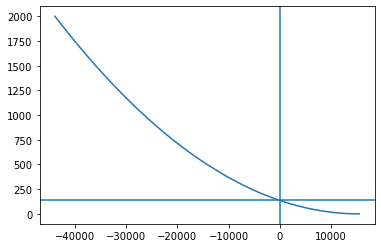

In [1078]:
fit(generate_population())

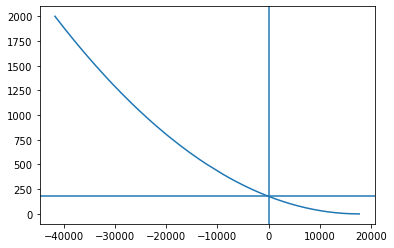

In [1076]:
population = generate_population()
Hour_S = population[0]
Hour_D = population[1]
Block_S = population[4]
Block_D = population[5]
Flex_S = population[2]
Flex_D = population[3]


In [1073]:
sum((Pairs(j,h,HS_bids,'SP')[1]-Pairs(j,h,HS_bids,'SP')[0]) * Hour_S[h][j] for j in range(len(Hour_S[h])))

145.9337219730941

In [1074]:
2000+sum((Pairs(j,h,HD_bids,'DP')[1]-Pairs(j,h,HD_bids,'DP')[0]) * Hour_D[h][j] for j in range(len(Hour_D[h])))


145.933721973096